# Create indexers and skills with the REST API

## Indexers, skillsets, datasources

Create with POST: POST https://myservice.search.windows.net/indexers?api-version=2023-11-01
Create or update: PUT https://myservice.search.windows.net/indexers('myindexer')?api-version=2023-11-01

Other operations see: https://learn.microsoft.com/en-us/rest/api/searchservice/indexers?view=rest-searchservice-2023-11-01

Important: include **api-key** header


## Create the index

Below, we define a function that returns an index definition. The index definition contains the fields of the index and a vector profile.

Next, we use a SearchIndexClient to create the index in Azure AI Search. This will fail if the index already exists. To create a new index, delete the index in the portal and run the code again.

In [24]:
import dotenv
import os
import requests
import json

dotenv.load_dotenv("../.env")

# Create index

def blog_index(name: str):
    from azure.search.documents.indexes.models import (
        SearchIndex,
        SearchField,
        SearchFieldDataType,
        SimpleField,
        SearchableField,
        VectorSearch,
        VectorSearchProfile,
        HnswAlgorithmConfiguration,
    )

    fields = [
        SimpleField(name="path", type=SearchFieldDataType.String, key=True),
        SimpleField(name="name", type=SearchFieldDataType.String, searchable=True),
        SimpleField(name="url", type=SearchFieldDataType.String, searchable=True),
        SimpleField(name="description", type=SearchFieldDataType.String, searchable=True),
        # enrichments will be dumped in enriched field if present; should show vectors & description
        SimpleField(name="enriched", type=SearchFieldDataType.String, searchable=False),  # debugging only
        SearchField(
            name="imageVector",
            type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
            searchable=True,
            vector_search_dimensions=1024,
            vector_search_profile_name="vector_config"
        ),
        SearchField(
            name="textVector",
            type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
            searchable=True,
            vector_search_dimensions=1536,
            vector_search_profile_name="vector_config"
        ),

    ]

    vector_search = VectorSearch(
        profiles=[VectorSearchProfile(name="vector_config", algorithm_configuration_name="algo_config")],
        algorithms=[HnswAlgorithmConfiguration(name="algo_config")],
    )
    return SearchIndex(name=name, fields=fields, vector_search=vector_search)

#  create the index
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import VectorizedQuery

service_endpoint = "https://acs-geba.search.windows.net"
index_name = "images"
key = os.getenv("AZURE_AI_SEARCH_KEY")

index_client = SearchIndexClient(service_endpoint, AzureKeyCredential(key))
search_client = SearchClient(service_endpoint, index_name, AzureKeyCredential(key))
index = blog_index(index_name)

# create the index
try:
    index_client.create_index(index)
    print("Index created")
except Exception as e:
    print("Index probably already exists", e)



Index created


## Using the API

Below, we define a simple helper function to either list or create new resources using the API. Using the API is just another way of defining objects in Azure AI Search. We will use the API to list indexes, to create a data source, a skillset and an indexer.

In [18]:


def search_api(search_service, resource, method, apiVersion="2023-11-01", body=None):
    url = f"https://{search_service}.search.windows.net/{resource}?&api-version={apiVersion}"
    headers = {
        "Content-Type": "application/json",
        "api-key": os.getenv('AZURE_AI_SEARCH_KEY')
    }

    if method.lower() == "get":
        response = requests.get(url, headers=headers)
    elif method.lower() == "post" and body is not None:
        response = requests.post(url, headers=headers, data=body)
    
    return response.status_code, response

# Example usage:
code, response = search_api("acs-geba", "indexers", "get", "2023-11-01")
if code == 200:
    print(json.dumps(response.json(), indent=4))


{
    "@odata.context": "https://acs-geba.search.windows.net/$metadata#indexers",
    "value": [
        {
            "@odata.etag": "\"0x8DBF42ABBD30AA2\"",
            "name": "images-indexer",
            "description": "Indexes images from Azure Blob Storage",
            "dataSourceName": "images",
            "skillsetName": "images-skillset",
            "targetIndexName": "images",
            "disabled": null,
            "schedule": null,
            "parameters": {
                "batchSize": null,
                "maxFailedItems": 0,
                "maxFailedItemsPerBatch": 0,
                "base64EncodeKeys": null,
                "configuration": {
                    "dataToExtract": "allMetadata",
                    "parsingMode": "default",
                    "indexedFileNameExtensions": ".jpg"
                }
            },
            "fieldMappings": [
                {
                    "sourceFieldName": "metadata_storage_path",
                    "tar

## Creating a datasource

Below, we use the helper function above to create a data source using the API. The datasource definition is defined in body as JSON. We use a storage connection string to define how the indexer should access the data source.

The data source and container should already exist.

Because we use POST, we will get an error when the data source already exists.

In [19]:
# create a data source
connection_string = os.getenv('STORAGE_CONNNECTION_STRING')

if not connection_string:
    raise ValueError("STORAGE_CONNNECTION_STRING is not set in the environment variables")


body = {
  "name": "images",
  "description": "images ds",
  "type": "azureblob",
  "credentials": {
    "connectionString": f"{connection_string}"
  },
  "container": {
    "name": "images"
  }
}

code, response = search_api("acs-geba", "datasources", "post", "2023-11-01", body=json.dumps(body))
print(code, response.json())

400 {'error': {'code': '', 'message': "Cannot create data source 'images' because a data source with that name already exists"}}


## Creating a skillset

Similarly to the data source, we use the API to define a skillset using a skillset definition in JSON.

The skillset defines two skills:
- AzureOpenAIEmbeddingSkill: a built-in skill that should be pointed to a text embedding model; it takes the description field in the index and vectorizes it to a field called textVector; note that this skill will only run after the custom skill because that skill creates the description field

- a custom WebApiSkill: the custom skill use the endpoint in the **uri** field to create an image vector of the image and an image description of the image; it does so for four images in a batch and can start 4 concurrent jobs; it takes the **url** to the image in blob storage as input and generates both the **imageVector** and the **description**

Because we use POST, you will get an error if the skill already exists.

In [20]:
# create a skillset

azure_ai_key = os.getenv('AZURE_OPENAI_KEY')

if not azure_ai_key:
    raise ValueError("AZURE_OPENAI_KEY is not set in the environment variables")

body = {
  "name": "images-skillset",
  "description": "skillset for images",
  "skills": [
    {
      "@odata.type": "#Microsoft.Skills.Text.AzureOpenAIEmbeddingSkill",
      "name": "embed",
      "description": "Embedding skillset",
      "context": "/document",
      "resourceUri": "https://oa-geba-france.openai.azure.com",
      "apiKey": f"{azure_ai_key}",
      "deploymentId": "embedding",
      "inputs": [
        {
          "name": "text",
          "source": "/document/description"
        }
      ],
      "outputs": [
        {
          "name": "embedding",
          "targetName": "textVector"
        }
      ]
    },
    {
      "@odata.type": "#Microsoft.Skills.Custom.WebApiSkill",
      "description": "A custom skill that creates an image vector",
      "uri": "https://myskill.gentlebay-4474176e.westeurope.azurecontainerapps.io/vectorize",
      "batchSize": 4,
      "degreeOfParallelism": 4,
      "context": "/document",
      "inputs": [
        {
          "name": "url",
          "source": "/document/url"
        }
      ],
      "outputs": [
        {
          "name": "embedding",
          "targetName": "imageVector"
        },
        {
          "name": "description",
          "targetName": "description"
        }
      ]
    }
  ]
}

code, response = search_api("acs-geba", "skillsets", "POST", "2023-10-01-Preview", body=json.dumps(body))
print(code, response.json())

400 {'error': {'code': '', 'message': "Cannot create skillset 'images-skillset' because a skillset with that name already exists"}}


## Indexer

The indexer performs the actual work. It takes the files from the data source as input and retrieves only the metadata like the filename, the url, etc...

In **fieldMappings** it maps certain well-known metadata fields to fields in the index. For one field, path, it does so by base64-encoding the **metadata_storage_path** field the indexer retrieves from blob storage.

The indexer is also responsible for saving the fields generated by skills to the index. The skills generate 3 fields:
- description
- imageVector
- textVector

In this example, the generated fields match the actual fields in the index but that is not required. The **outputFieldMappings** are responsible for writing the fields generated by skills (see them as temporary) to the fields in the index.

In [23]:
# create an indexer
body = {
  "name": "images-indexer",
  "description": "Indexes images from Azure Blob Storage",
  "dataSourceName": "images",
  "skillsetName": "images-skillset",
  "cache" : {
            "storageConnectionString" : f"{connection_string}",
            "enableReprocessing": True
        },
  "targetIndexName": "images",
  "parameters": {
    "maxFailedItems": 0,
    "maxFailedItemsPerBatch": 0,
    "configuration": {
      "dataToExtract": "allMetadata",
      "parsingMode": "default",
      "indexedFileNameExtensions": ".jpg"
    }
  },
  "fieldMappings": [
    {
      "sourceFieldName": "metadata_storage_path",
      "targetFieldName": "path",
      "mappingFunction": {
        "name": "base64Encode"
      }
    },
    {
      "sourceFieldName": "metadata_storage_name",
      "targetFieldName": "name"
    },
    {
      "sourceFieldName": "metadata_storage_path",
      "targetFieldName": "url"
    }
  ],
  "outputFieldMappings": [
    {
      "sourceFieldName": "/document/textVector",
      "targetFieldName": "textVector"
    },
    {
      "sourceFieldName": "/document/imageVector",
      "targetFieldName": "imageVector"
    },
    {
      "sourceFieldName": "/document/description",
      "targetFieldName": "description"
    }
  ]
}

code, response = search_api("acs-geba", "indexers", "POST", apiVersion="2021-04-30-Preview", body=json.dumps(body))
print(code, response.json())

201 {'@odata.context': 'https://acs-geba.search.windows.net/$metadata#indexers/$entity', '@odata.etag': '"0x8DBF4C418D41295"', 'name': 'images-indexer', 'description': 'Indexes images from Azure Blob Storage', 'dataSourceName': 'images', 'skillsetName': 'images-skillset', 'targetIndexName': 'images', 'disabled': None, 'schedule': None, 'parameters': {'batchSize': None, 'maxFailedItems': 0, 'maxFailedItemsPerBatch': 0, 'base64EncodeKeys': None, 'configuration': {'dataToExtract': 'allMetadata', 'parsingMode': 'default', 'indexedFileNameExtensions': '.jpg'}}, 'fieldMappings': [{'sourceFieldName': 'metadata_storage_path', 'targetFieldName': 'path', 'mappingFunction': {'name': 'base64Encode', 'parameters': None}}, {'sourceFieldName': 'metadata_storage_name', 'targetFieldName': 'name', 'mappingFunction': None}, {'sourceFieldName': 'metadata_storage_path', 'targetFieldName': 'url', 'mappingFunction': None}], 'outputFieldMappings': [{'sourceFieldName': '/document/textVector', 'targetFieldName'

## Searching for images based on text

Below, we define a helper function that can turn a query into a text vector using the same model as used by the embedding skill. We use OpenAI (not Azure OpenAI) to do so.

Next, we define a function to download an image from blob storage. That allows us to show the image in the notebook later. Remember that our index does not contain the image data, only metadata like the url.

Next, we define a function that can perform a vector search with the Azure AI Python SDK.

minion.jpg: The image features two animated characters known as Minions, from the Despicable Me film series. They are small, yellow creatures with distinctive goggles and blue overalls. One has one eye and appears to be holding a red object that might be a tool or a weapon, while the other one has two eyes and both have their mouths wide open as if they are talking or expressing excitement or surprise. They are standing in what looks like a futuristic environment with blue lighting in the background.


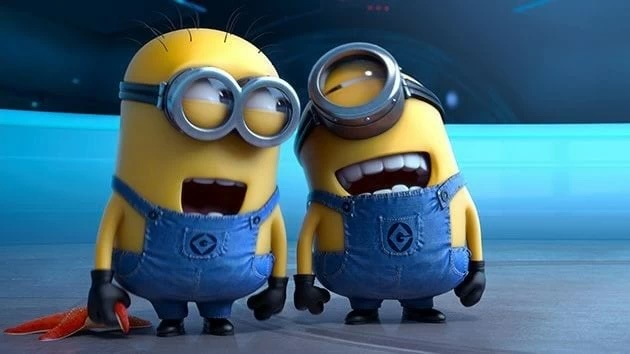

In [16]:
# now search based on text
from openai import OpenAI
from azure.storage.blob import BlobServiceClient
client = OpenAI()

def get_text_vector(text: str):
    embedding = client.embeddings.create(input=[text], model="text-embedding-ada-002")
    return embedding.data[0].embedding

def download_from_azure_storage(url):
        # extract container name and filename from the url
        container_name = url.split('/')[3]
        blob_name = url.split('/')[4]

        # Create a blob service client
        blob_service_client = BlobServiceClient.from_connection_string(os.getenv("STORAGE_CONNNECTION_STRING"))

        # Access the container and blob
        try:
            blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

            # Download the blob
            blob_data = blob_client.download_blob().readall()
            return blob_data
        except Exception as e:
            logger.error(f"Error: {e}")
            return None

def single_vector_search(query: str):
    vector_query = VectorizedQuery(vector=get_text_vector(query), k_nearest_neighbors=1, fields="textVector", exhaustive=True)

    results = search_client.search(
        vector_queries=[vector_query],
        select=["name", "description", "url"],
        
    )

    for result in results:
        print(result['name'], result["description"], sep=": ")
        image = download_from_azure_storage(result["url"])

        # display image
        from IPython.display import Image
        display(Image(image))


single_vector_search("person")